**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Write your code here
import numpy as np
from types import SimpleNamespace
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [2]:
par = SimpleNamespace()

# firms
par.A = 1.0
par.gamma = 0.5

# households
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0

# government
par.tau = 0.0
par.T = 0.0

# Question 3
par.kappa = 0.1

In [3]:
# Answers 
import numpy as np
from types import SimpleNamespace
from scipy.optimize import minimize_scalar

# Parameters
par = SimpleNamespace()
par.A = 1.0
par.gamma = 0.5
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0
par.tau = 0.0
par.T = 0.0
par.kappa = 0.1  # Social cost of carbon

# Utility function
def utility(c1, c2, l, alpha, nu, epsilon):
    return np.log(c1**alpha * c2**(1 - alpha)) - nu * l**(1 + epsilon) / (1 + epsilon)

# Budget constraint function
def budget_constraint(l, w, p1, p2, tau, T, pi1, pi2, alpha):
    income = w * l + T + pi1 + pi2
    c1 = alpha * income / p1
    c2 = (1 - alpha) * income / (p2 + tau)
    return c1, c2

# Labor supply function
def labor_supply(w, p1, p2, tau, T, A, gamma, alpha, nu, epsilon):
    pi1 = (p1 * A**gamma / w)**(1 / (1 - gamma))
    pi2 = (p2 * A**gamma / w)**(1 / (1 - gamma))
    
    def objective(l):
        c1, c2 = budget_constraint(l, w, p1, p2, tau, T, pi1, pi2, alpha)
        return -utility(c1, c2, l, alpha, nu, epsilon)
    
    result = minimize_scalar(objective, bounds=(1e-5, 100), method='bounded')
    return result.x

# Market clearing conditions function
def market_clearing_conditions(p1, p2, par):
    w = 1  # Explicitly setting w = 1 as the numeraire
    l_star = labor_supply(w, p1, p2, par.tau, par.T, par.A, par.gamma, par.alpha, par.nu, par.epsilon)
    y1_star = par.A * l_star**par.gamma
    y2_star = par.A * l_star**par.gamma
    return l_star, y1_star, y2_star

# Check market clearing conditions with w = 1 (numeraire)
p1_values = np.linspace(0.1, 2.0, 10)
p2_values = np.linspace(0.1, 2.0, 10)
results = []

for p1 in p1_values:
    for p2 in p2_values:
        l_star, y1_star, y2_star = market_clearing_conditions(p1, p2, par)  # w = 1 is set inside the function
        results.append((p1, p2, l_star, y1_star, y2_star))

# Print a summary of the results
print("Summary of market clearing conditions for selected p1 and p2 values:")
for i, (p1, p2, l_star, y1_star, y2_star) in enumerate(results):
    if i % 10 == 0:  # Print every 10th result to reduce output
        print(f"p1: {p1:.2f}, p2: {p2:.2f}, l*: {l_star:.4f}, y1*: {y1_star:.4f}, y2*: {y2_star:.4f}")

Summary of market clearing conditions for selected p1 and p2 values:
p1: 0.10, p2: 0.10, l*: 0.9934, y1*: 0.9967, y2*: 0.9967
p1: 0.31, p2: 0.10, l*: 0.9656, y1*: 0.9827, y2*: 0.9827
p1: 0.52, p2: 0.10, l*: 0.9141, y1*: 0.9561, y2*: 0.9561
p1: 0.73, p2: 0.10, l*: 0.8468, y1*: 0.9202, y2*: 0.9202
p1: 0.94, p2: 0.10, l*: 0.7727, y1*: 0.8791, y2*: 0.8791
p1: 1.16, p2: 0.10, l*: 0.6993, y1*: 0.8363, y2*: 0.8363
p1: 1.37, p2: 0.10, l*: 0.6313, y1*: 0.7945, y2*: 0.7945
p1: 1.58, p2: 0.10, l*: 0.5707, y1*: 0.7555, y2*: 0.7555
p1: 1.79, p2: 0.10, l*: 0.5179, y1*: 0.7197, y2*: 0.7197
p1: 2.00, p2: 0.10, l*: 0.4723, y1*: 0.6873, y2*: 0.6873


Summary of market clearing conditions for selected p1 and p2 values:
p1: 0.10, p2: 0.10, l*: 0.9934, y1*: 0.9967, y2*: 0.9967, c1*: 3.0101, c2*: 7.0236
p1: 0.31, p2: 0.10, l*: 0.9656, y1*: 0.9827, y2*: 0.9827, c1*: 0.9826, c2*: 7.1332
p1: 0.52, p2: 0.10, l*: 0.9141, y1*: 0.9561, y2*: 0.9561, c1*: 0.6063, c2*: 7.3881
p1: 0.73, p2: 0.10, l*: 0.8468, y1*: 0.9202, y2*: 0.9202, c1*: 0.4585, c2*: 7.8448
p1: 0.94, p2: 0.10, l*: 0.7727, y1*: 0.8791, y2*: 0.8791, c1*: 0.3887, c2*: 8.5661
p1: 1.16, p2: 0.10, l*: 0.6993, y1*: 0.8363, y2*: 0.8363, c1*: 0.3562, c2*: 9.6040
p1: 1.37, p2: 0.10, l*: 0.6313, y1*: 0.7945, y2*: 0.7945, c1*: 0.3447, c2*: 10.9914
p1: 1.58, p2: 0.10, l*: 0.5707, y1*: 0.7555, y2*: 0.7555, c1*: 0.3461, c2*: 12.7429
p1: 1.79, p2: 0.10, l*: 0.5179, y1*: 0.7197, y2*: 0.7197, c1*: 0.3560, c2*: 14.8608
p1: 2.00, p2: 0.10, l*: 0.4723, y1*: 0.6873, y2*: 0.6873, c1*: 0.3716, c2*: 17.3413


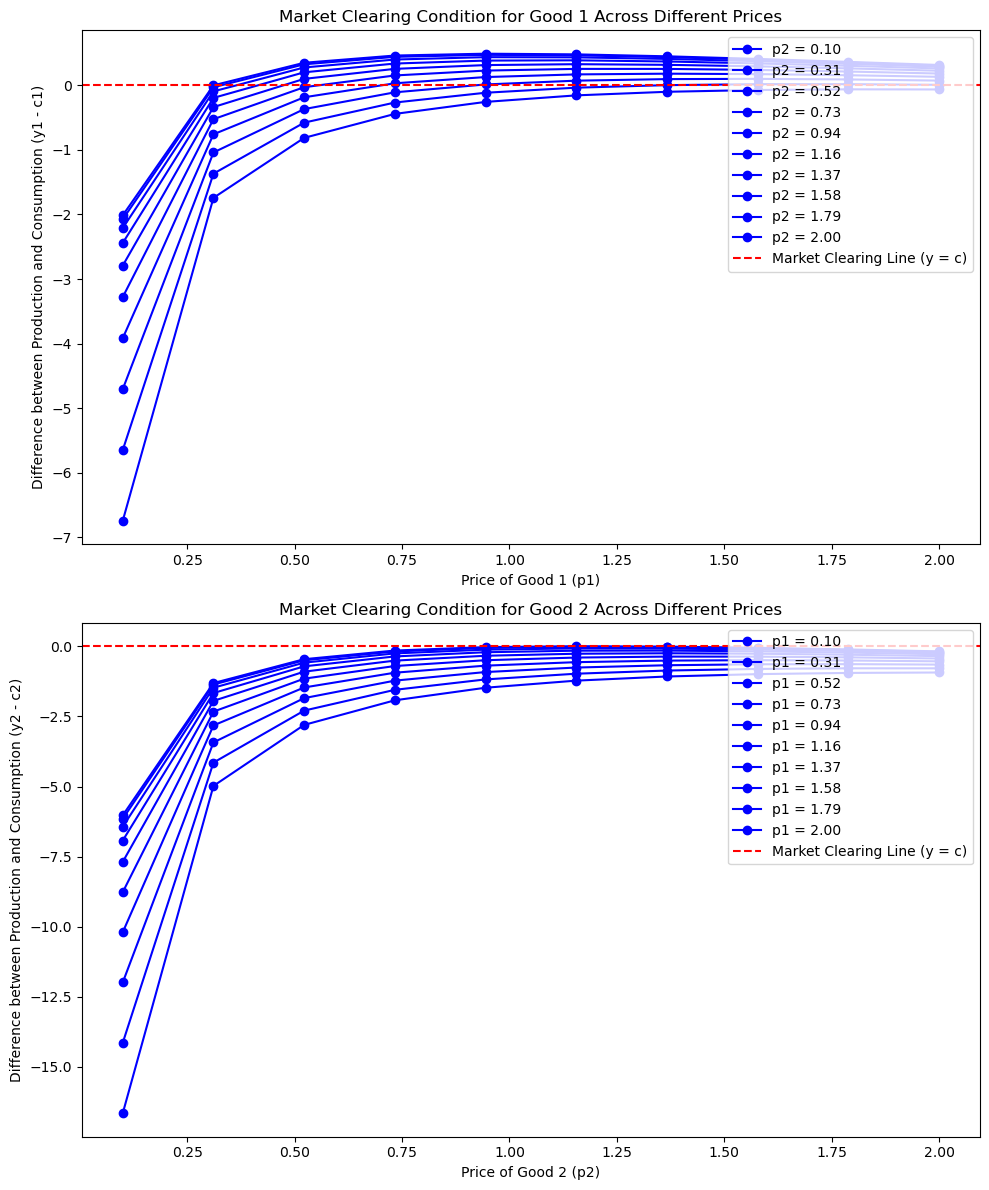

In [4]:
def profit_1(w, p1):
    return (p1 * par.A**par.gamma / w)**(1 / (1 - par.gamma)) * w * (1 - par.gamma)

def profit_2(w, p2):
    return (p2 * par.A**par.gamma / w)**(1 / (1 - par.gamma)) * w * (1 - par.gamma)

def market_clearing_conditions2(p1, p2, par):
    w = 1  # Explicitly setting w = 1 as the numeraire
    l_star = labor_supply(w, p1, p2, par.tau, par.T, par.A, par.gamma, par.alpha, par.nu, par.epsilon)
    y1_star = par.A * l_star**par.gamma
    y2_star = par.A * l_star**par.gamma
    c1_star = par.alpha * (w * l_star + par.T + profit_1(w, p1) + profit_2(w, p2)) / p1
    c2_star = (1 - par.alpha) * (w * l_star + par.T + profit_1(w, p1) + profit_2(w, p2)) / (p2 + par.tau)
    return l_star, y1_star, y2_star, c1_star, c2_star

# Check market clearing conditions with w = 1 (numeraire)
p1_values = np.linspace(0.1, 2.0, 10)
p2_values = np.linspace(0.1, 2.0, 10)
results = []

y1_c1_diff = np.zeros((10, 10))
y2_c2_diff = np.zeros((10, 10))

for i, p1 in enumerate(p1_values):
    for j, p2 in enumerate(p2_values):
        l_star, y1_star, y2_star, c1_star, c2_star = market_clearing_conditions2(p1, p2, par)
        y1_c1_diff[i, j] = y1_star - c1_star
        y2_c2_diff[i, j] = y2_star - c2_star
        results.append((p1, p2, l_star, y1_star, y2_star, c1_star, c2_star))

# Print a summary of the results
print("Summary of market clearing conditions for selected p1 and p2 values:")
for i, (p1, p2, l_star, y1_star, y2_star, c1_star, c2_star) in enumerate(results):
    if i % 10 == 0:  # Print every 10th result to reduce output
        print(f"p1: {p1:.2f}, p2: {p2:.2f}, l*: {l_star:.4f}, y1*: {y1_star:.4f}, y2*: {y2_star:.4f}, c1*: {c1_star:.4f}, c2*: {c2_star:.4f}")

# Plot the results
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Good 1 market clearing
for i, p2 in enumerate(p2_values):
    axs[0].plot(p1_values, y1_c1_diff[:, i], 'bo-', label=f'p2 = {p2:.2f}')
axs[0].axhline(0, color='r', linestyle='--', label='Market Clearing Line (y = c)')
axs[0].set_title('Market Clearing Condition for Good 1 Across Different Prices')
axs[0].set_xlabel('Price of Good 1 (p1)')
axs[0].set_ylabel('Difference between Production and Consumption (y1 - c1)')
axs[0].legend(loc='upper right')

# Good 2 market clearing
for i, p1 in enumerate(p1_values):
    axs[1].plot(p2_values, y2_c2_diff[i, :], 'bo-', label=f'p1 = {p1:.2f}')
axs[1].axhline(0, color='r', linestyle='--', label='Market Clearing Line (y = c)')
axs[1].set_title('Market Clearing Condition for Good 2 Across Different Prices')
axs[1].set_xlabel('Price of Good 2 (p2)')
axs[1].set_ylabel('Difference between Production and Consumption (y2 - c2)')
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()


**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

In [5]:
# write your answer here
from scipy.optimize import fsolve

# Function to find equilibrium prices
def equilibrium_prices():
    def equations(p):
        p1, p2 = p
        l_star, y1_star, y2_star = market_clearing_conditions(p1, p2, par)  # w = 1 as numeraire
        c1, c2 = budget_constraint(l_star, 1, p1, p2, par.tau, par.T, y1_star, y2_star, par.alpha)
        # Market clearing conditions
        # Check only two markets as per Walras' law
        condition1 = y1_star - c1
        condition2 = y2_star - c2
        return [condition1, condition2]
    
    p1_p2_initial_guess = [1, 1]
    p1_p2_equilibrium = fsolve(equations, p1_p2_initial_guess)
    return p1_p2_equilibrium

# Find equilibrium prices
p1_eq, p2_eq = equilibrium_prices()
print(f"\nEquilibrium prices: p1: {p1_eq}, p2: {p2_eq}")


Equilibrium prices: p1: 0.8044596129475206, p2: 1.8770724302103687


Testing with multiple initial guesses to see if the equilibrium prices change:

In [6]:
# Function to find equilibrium prices with different initial guesses
def equilibrium_prices2(initial_guess):
    def equations(p):
        p1, p2 = p
        l_star, y1_star, y2_star = market_clearing_conditions(p1, p2, par)  # w = 1 as numeraire
        c1, c2 = budget_constraint(l_star, 1, p1, p2, par.tau, par.T, y1_star, y2_star, par.alpha)
        # Market clearing conditions
        condition1 = y1_star - c1
        condition2 = y2_star - c2
        return [condition1, condition2]
    
    p1_p2_equilibrium = fsolve(equations, initial_guess)
    return p1_p2_equilibrium

# Test different initial guesses
initial_guesses = [
    [1, 1],
    [0.5, 0.5],
    [1.5, 1.5],
    [0.1, 0.1]
]

for guess in initial_guesses:
    p1_eq, p2_eq = equilibrium_prices2(guess)
    print(f"Initial guess: {guess} -> Equilibrium prices: p1: {p1_eq}, p2: {p2_eq}")

Initial guess: [1, 1] -> Equilibrium prices: p1: 0.8044596129475206, p2: 1.8770724302103687
Initial guess: [0.5, 0.5] -> Equilibrium prices: p1: 0.8044596129512056, p2: 1.8770724302092578
Initial guess: [1.5, 1.5] -> Equilibrium prices: p1: 0.8044596129470134, p2: 1.8770724302095292
Initial guess: [0.1, 0.1] -> Equilibrium prices: p1: 0.8044596129390637, p2: 1.8770724302121524


The equilibrium prices are P1=0.8 and P2=1.88

Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

In [7]:
from scipy.optimize import minimize, minimize_scalar, fsolve

# Social welfare function
def social_welfare_function(params):
    tau, T = params
    par.tau = tau
    par.T = T
    p1_eq, p2_eq = equilibrium_prices()  # Find equilibrium prices with the current tau and T
    l_star, y1_star, y2_star = market_clearing_conditions(p1_eq, p2_eq, par)
    c1, c2 = budget_constraint(l_star, 1, p1_eq, p2_eq, tau, T, y1_star, y2_star, par.alpha)
    U = utility(c1, c2, l_star, par.alpha, par.nu, par.epsilon)
    SWF = U - par.kappa * y2_star  # Social welfare function
    return -SWF  # We minimize the negative social welfare to maximize it

# Optimize for tau and T
result = minimize(social_welfare_function, [0, 0], bounds=[(0, 2), (0, 2)])
optimal_tau, optimal_T = result.x
print(f"Optimal tau: {optimal_tau}, Optimal T: {optimal_T}")


Optimal tau: 1.9905731000571816, Optimal T: 0.10103959306334999


For the goverment to maximize SWF they should choose $\tau$=1.99 and T=0.1

## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [8]:
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000

par.F = np.arange(1,par.N+1)
par.sigma = 2

par.v = np.array([1,2,3])
par.c = 1

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


In [9]:
# write your answer here
def simulate_utility(par):
    # Set seed for reproducibility
    np.random.seed(0) 
    # Find the distribution of epsilon using the normal distribution and the sigma value
    epsilons = np.random.normal(0, par.sigma, (par.K, par.J)) 
    # Calculate the expected utility for each career choice using the simulation function above
    expected_utilities = par.v + np.mean(epsilons, axis = 0) 
    # Calculate the average utility across the 10000 draws
    average_realised_utilities = par.v + epsilons.mean(axis = 0)
    return expected_utilities, average_realised_utilities

expected_utility, average_realised_utility = simulate_utility(par)

print(f"Expected utility for career choice 1: {expected_utility[0]}")
print(f"Average realised utility for career choice 1: {average_realised_utility[0]}")
print(f"Expected utility for career choice 2: {expected_utility[1]}")
print(f"Average realised utility for career choice 2: {average_realised_utility[1]}")
print(f"Expected utility for career choice 3: {expected_utility[2]}")
print(f"Average realised utility for career choice 3: {average_realised_utility[2]}")
print(f"It is observed that the expected utilities and average realised utilities are the same since the expected mean of a normal distribution is 0.")

Expected utility for career choice 1: 0.9850682385395173
Average realised utility for career choice 1: 0.9850682385395173
Expected utility for career choice 2: 1.9992895711626144
Average realised utility for career choice 2: 1.9992895711626144
Expected utility for career choice 3: 2.989425078605825
Average realised utility for career choice 3: 2.989425078605825
It is observed that the expected utilities and average realised utilities are the same since the expected mean of a normal distribution is 0.


Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

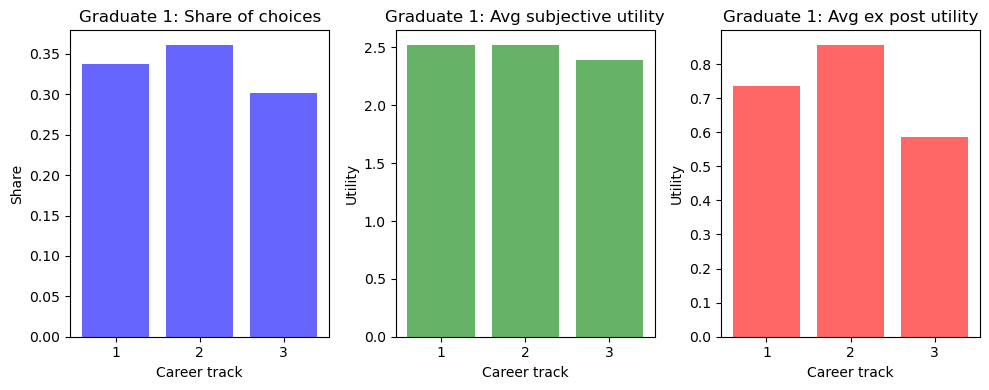

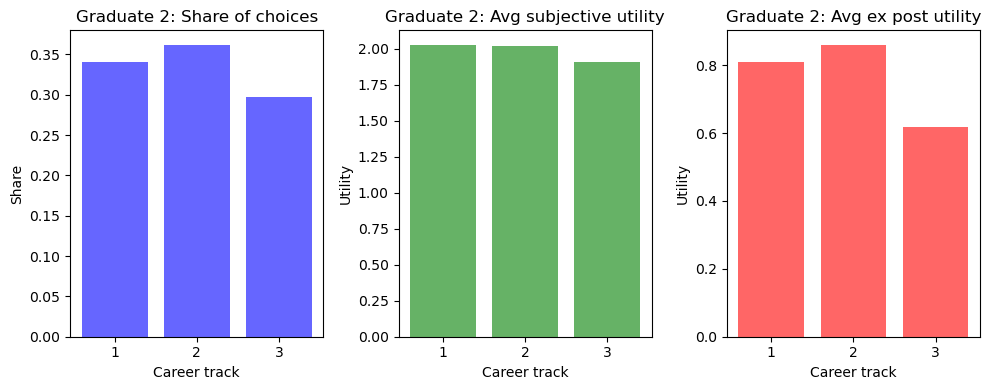

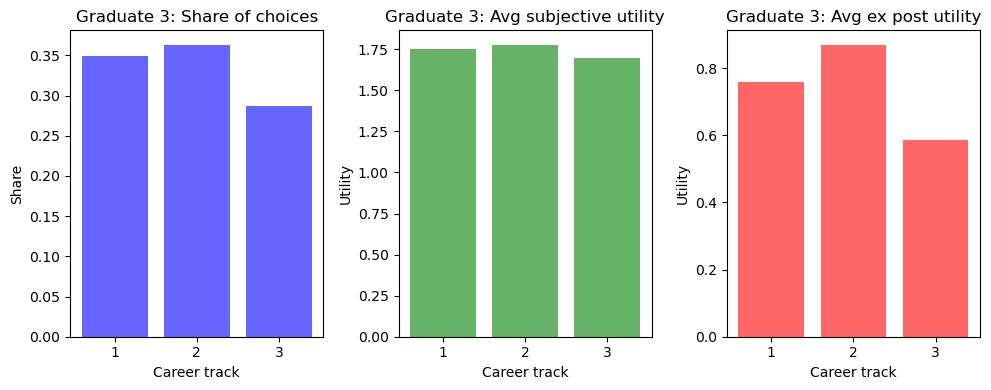

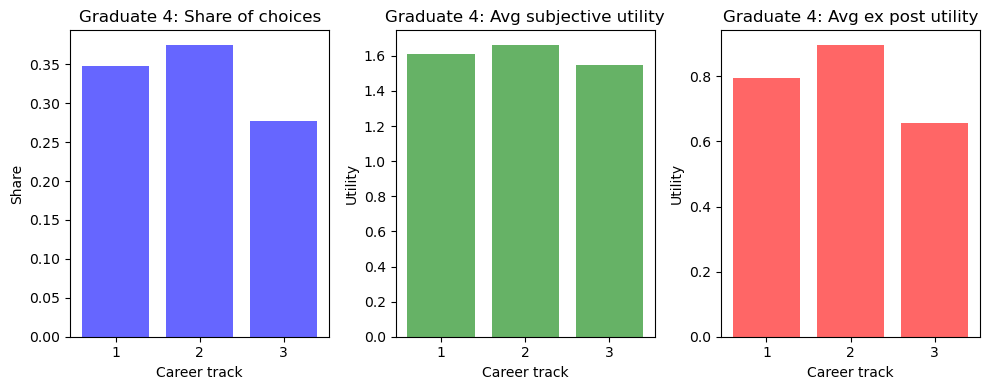

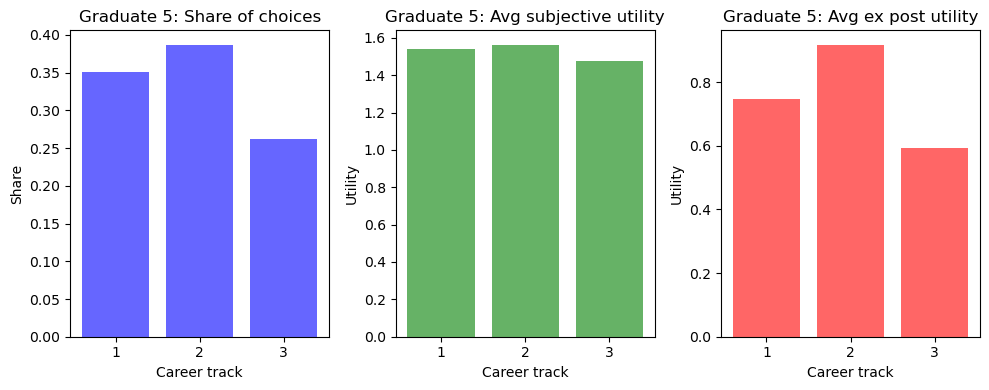

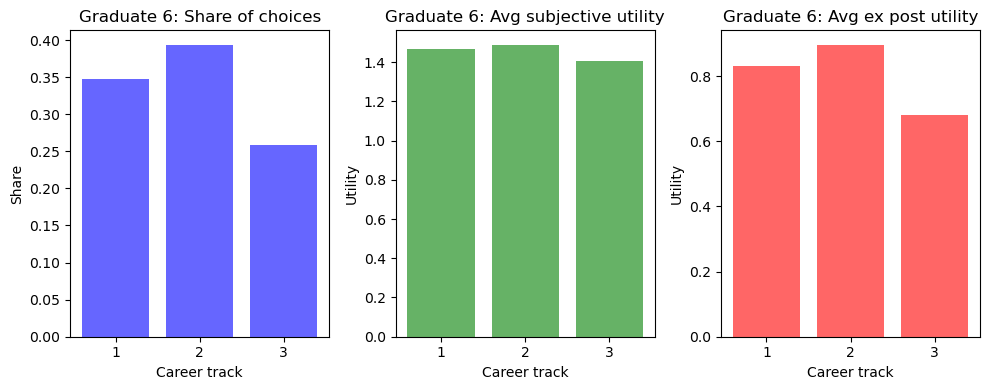

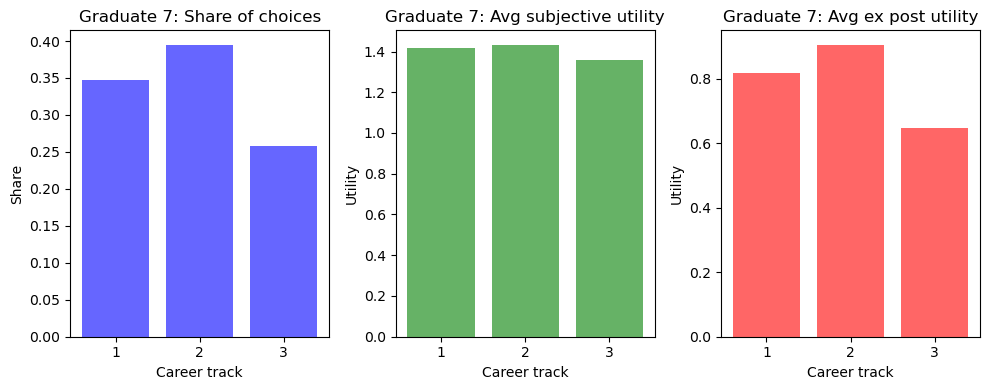

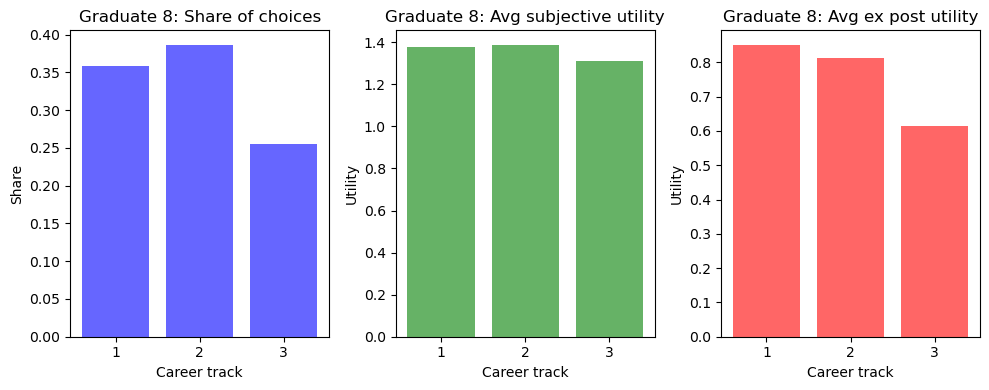

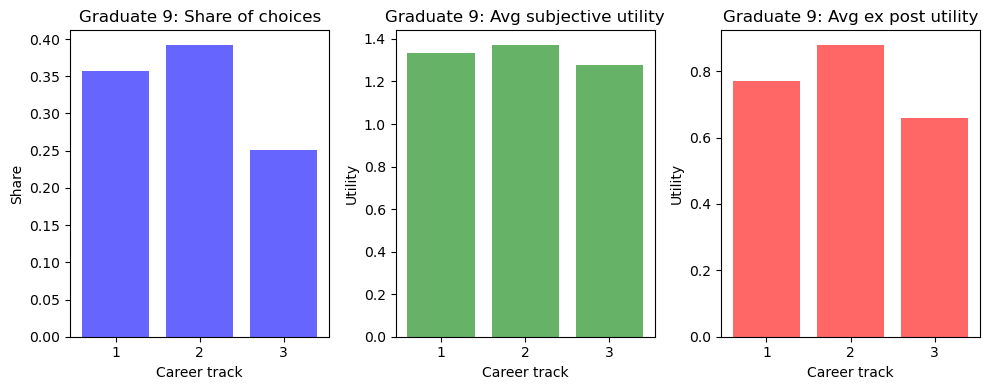

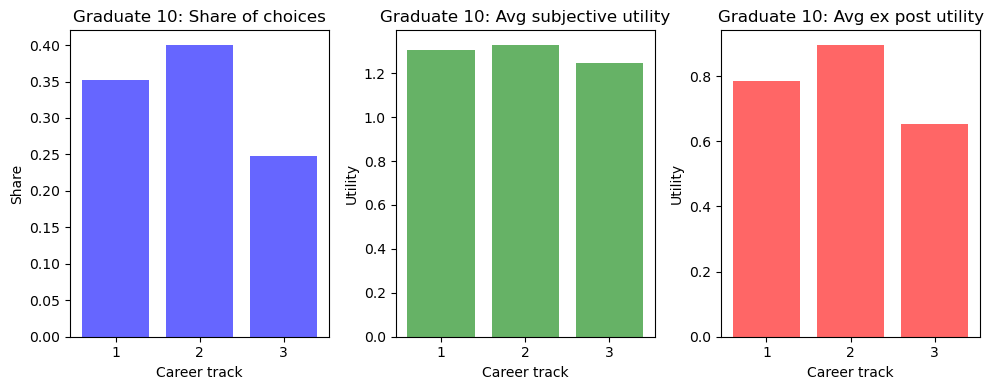

In [10]:
# Write your answer here 
# Arrays to store results
share_of_choices = np.zeros((par.N, par.J))
average_subjective_expected_utility = np.zeros((par.N, par.J))
average_ex_post_realised_utility = np.zeros((par.N, par.J))
vj = np.random.rand(par.J) # Randomly generate a value between 0 and 1 for the true utility for each career track

for i in range(1, par.N + 1):
    # Number of friends for each graduate i
    Fi = i 
    # Arrays to store results from simulation
    choices = np.zeros((par.K, par.J))
    subjective_expected_utility = np.zeros((par.K, par.J))
    ex_post_realised_utility = np.zeros((par.K, par.J))

    for k in range(par.K):
        # Draw friends' noise terms
        friends_noise_terms = np.random.normal(0,par.sigma, size = (Fi, par.J))

        # Calculate prior expected utility for each career track j
        prior_expected_utilities = vj + np.mean(friends_noise_terms, axis=0)
                
        # Determine career choice with maximum prior expected utility
        chosen_index = np.argmax(prior_expected_utilities)
        choices[k] = chosen_index
        
        # Store subjective expected utilities in array
        subjective_expected_utility[k] = prior_expected_utilities[chosen_index]

        # Draw individual's noise term
        own_noise_term = np.random.normal(0, par.sigma, size = par.J)
        ex_post_realised_utility[k] = vj[chosen_index] + own_noise_term[chosen_index]
    
    # Calculate averages across simulations 
    for j in range(par.J):
        share_of_choices[i - 1, j] = np.mean(choices == j)
        if np.sum(choices == j) > 0:  # Avoid division by zero
            average_subjective_expected_utility[i - 1, j] = np.mean(subjective_expected_utility[choices == j])
            average_ex_post_realised_utility[i - 1, j] = np.mean(ex_post_realised_utility[choices == j])

# Visualise the results using bar charts 
career_tracks = np.arange(1, par.J+1)
for i in range(par.N):
    plt.figure(figsize=(10, 4))
    
    # Share of graduates choosing each career
    plt.subplot(1, 3, 1)
    plt.bar(career_tracks, share_of_choices[i, :], color='b', alpha=0.6)
    plt.title(f'Graduate {i+1}: Share of choices')
    plt.xlabel('Career track')
    plt.ylabel('Share')
    plt.xticks(career_tracks)
    
    # Average subjective expected utility
    plt.subplot(1, 3, 2)
    plt.bar(career_tracks, average_subjective_expected_utility[i, :], color='g', alpha=0.6)
    plt.title(f'Graduate {i+1}: Avg subjective utility')
    plt.xlabel('Career track')
    plt.ylabel('Utility')
    plt.xticks(career_tracks)
    
    # Average ex post realized utility
    plt.subplot(1, 3, 3)
    plt.bar(career_tracks, average_ex_post_realised_utility[i, :], color='r', alpha=0.6)
    plt.title(f'Graduate {i+1}: Avg ex post utility')
    plt.xlabel('Career track')
    plt.ylabel('Utility')
    plt.xticks(career_tracks)
    
    plt.tight_layout()
    plt.show()

After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

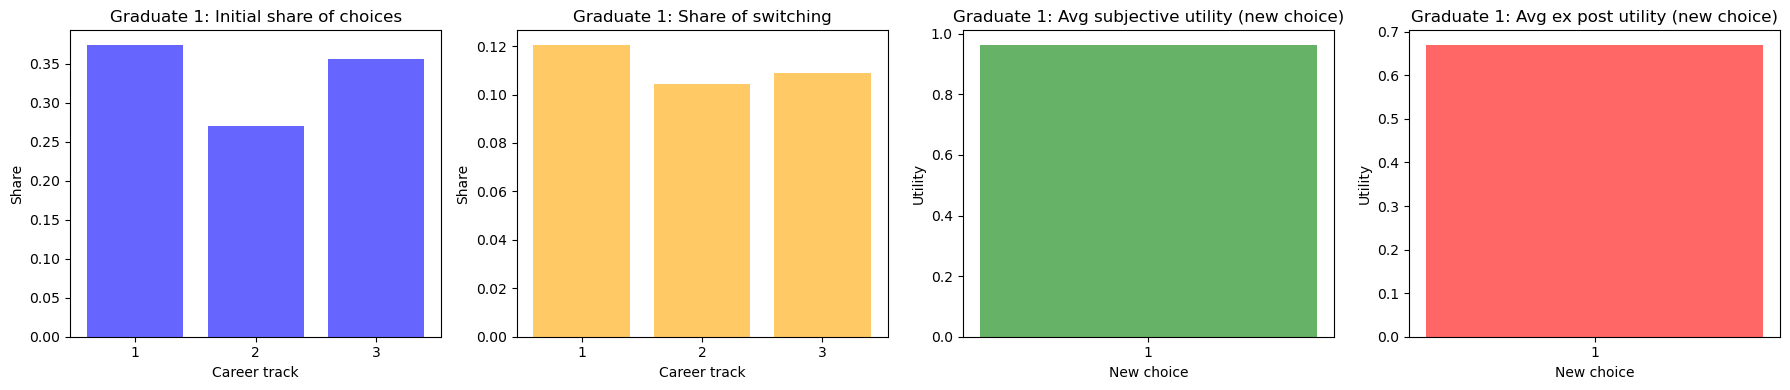

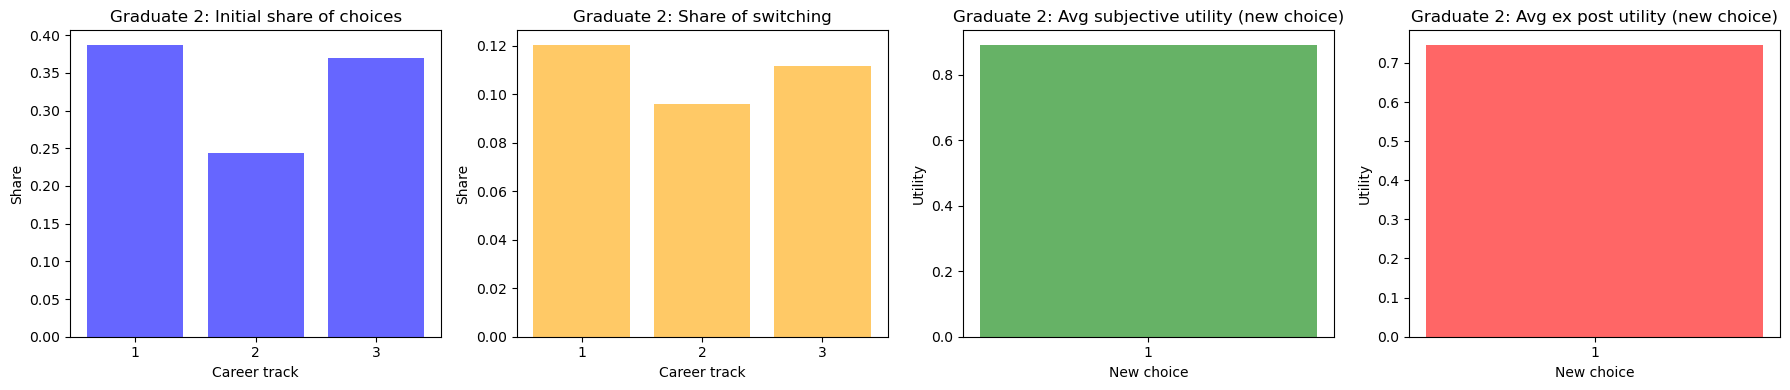

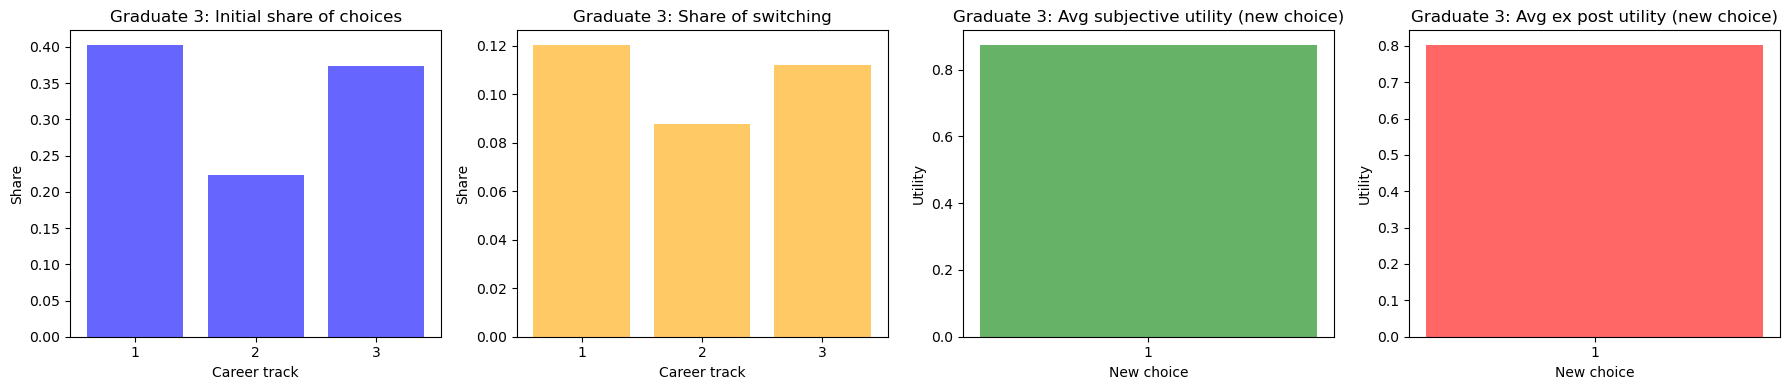

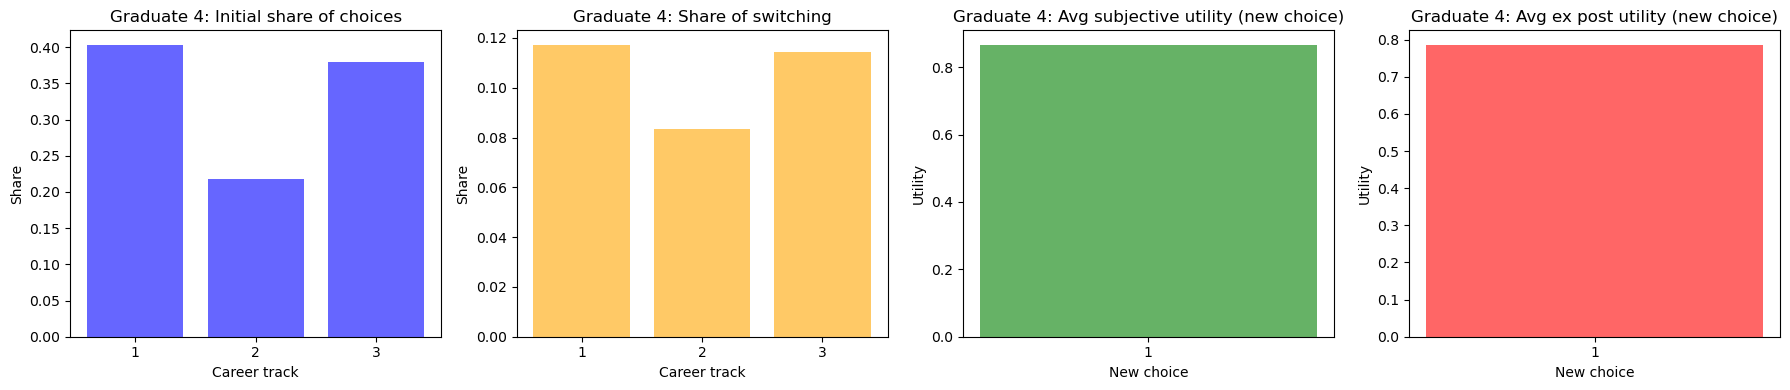

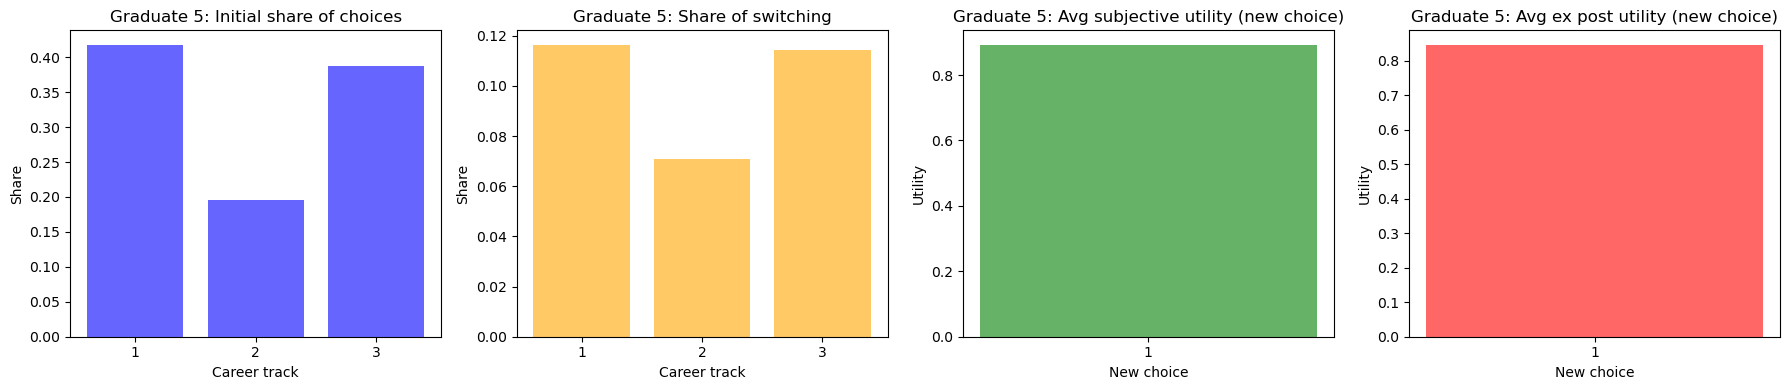

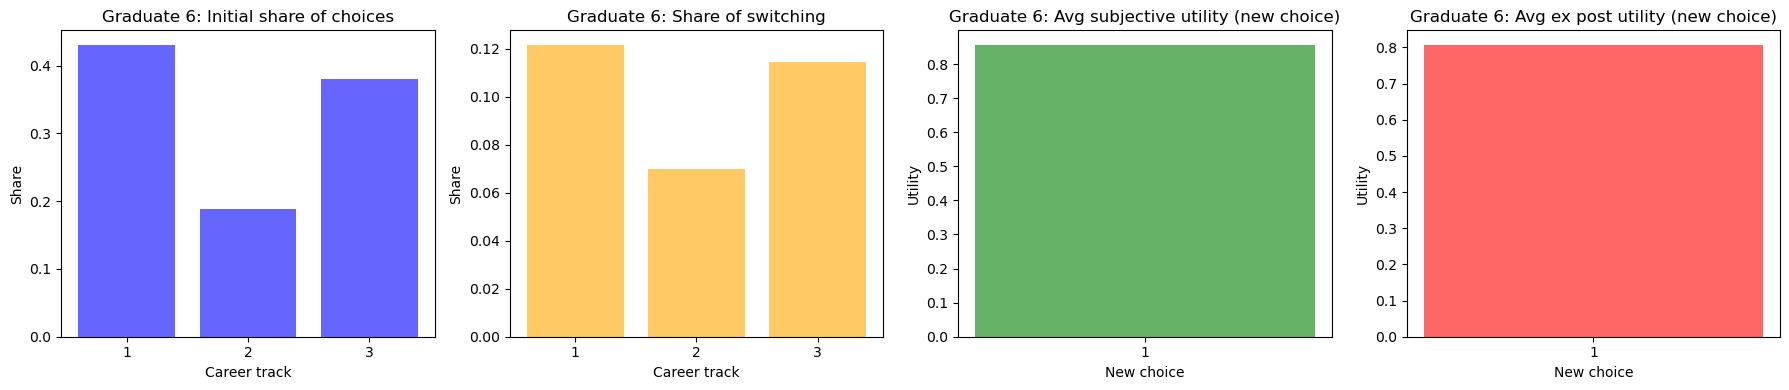

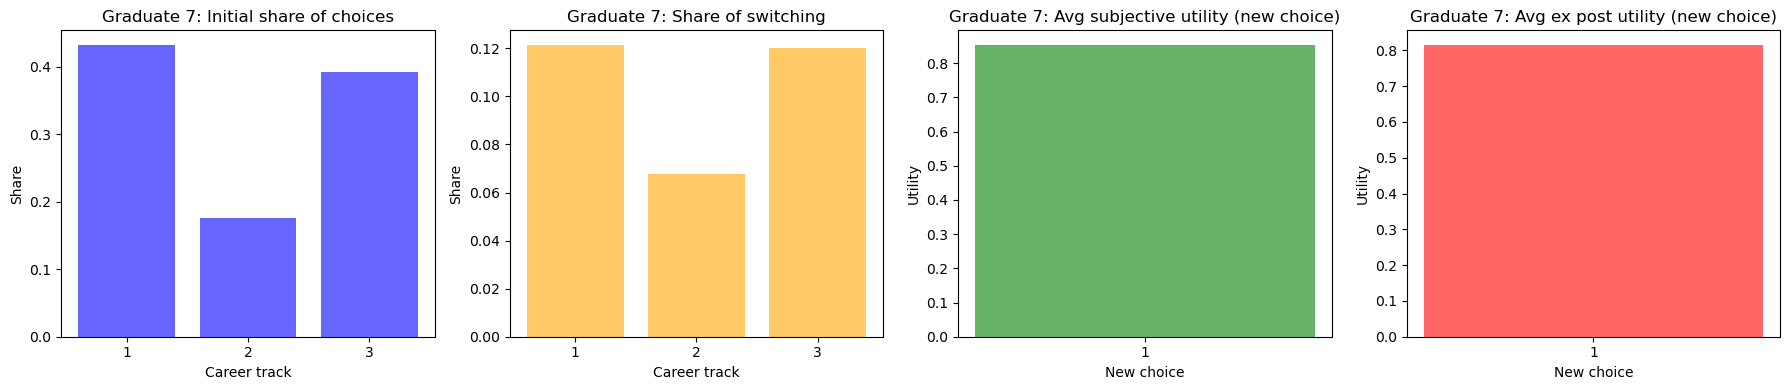

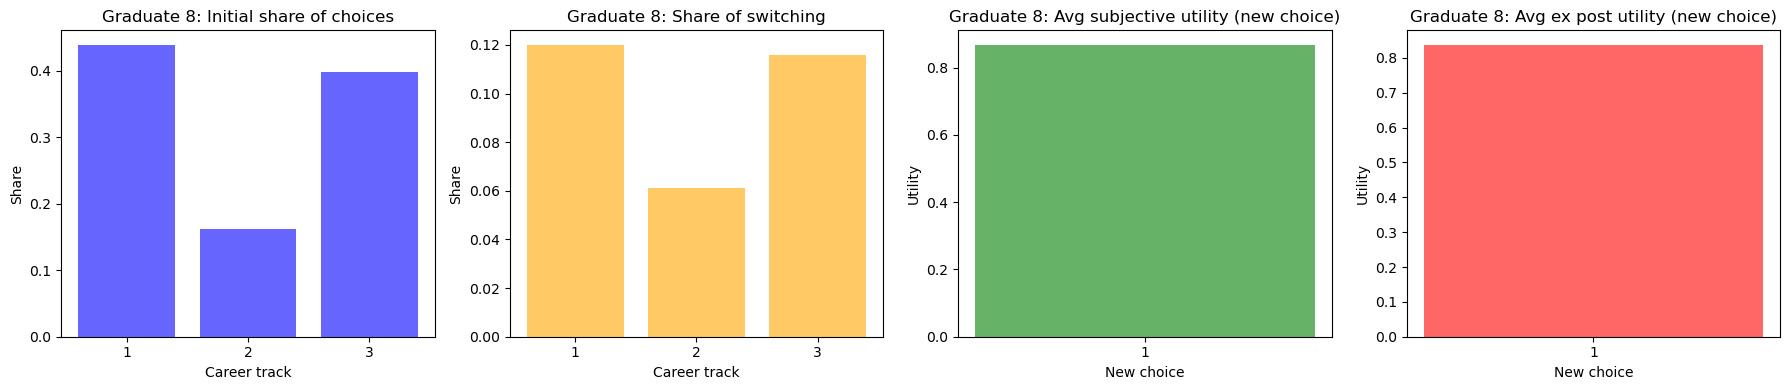

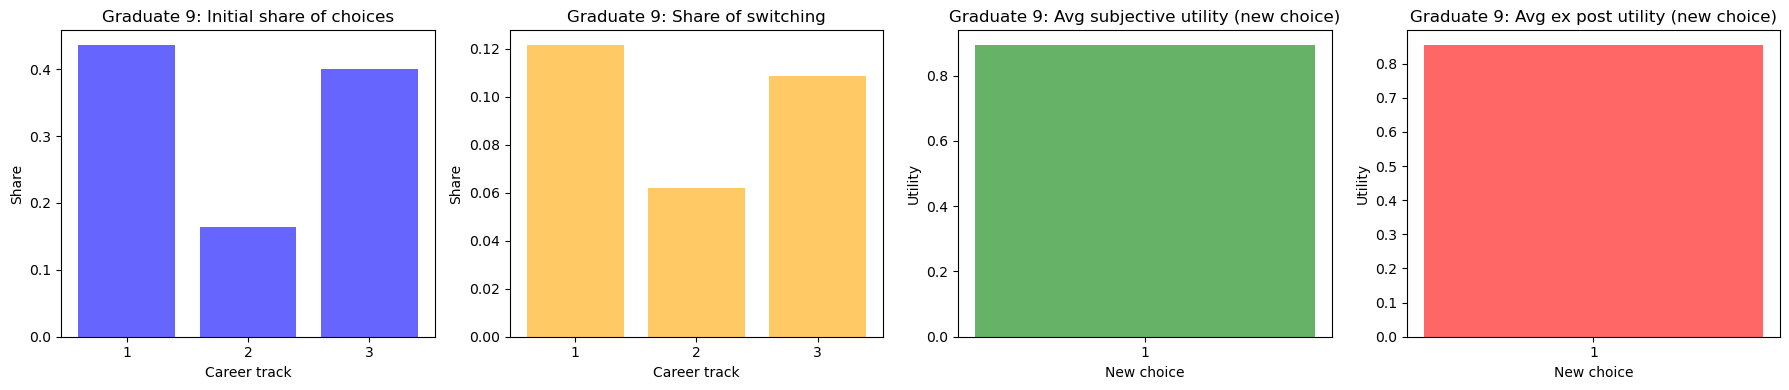

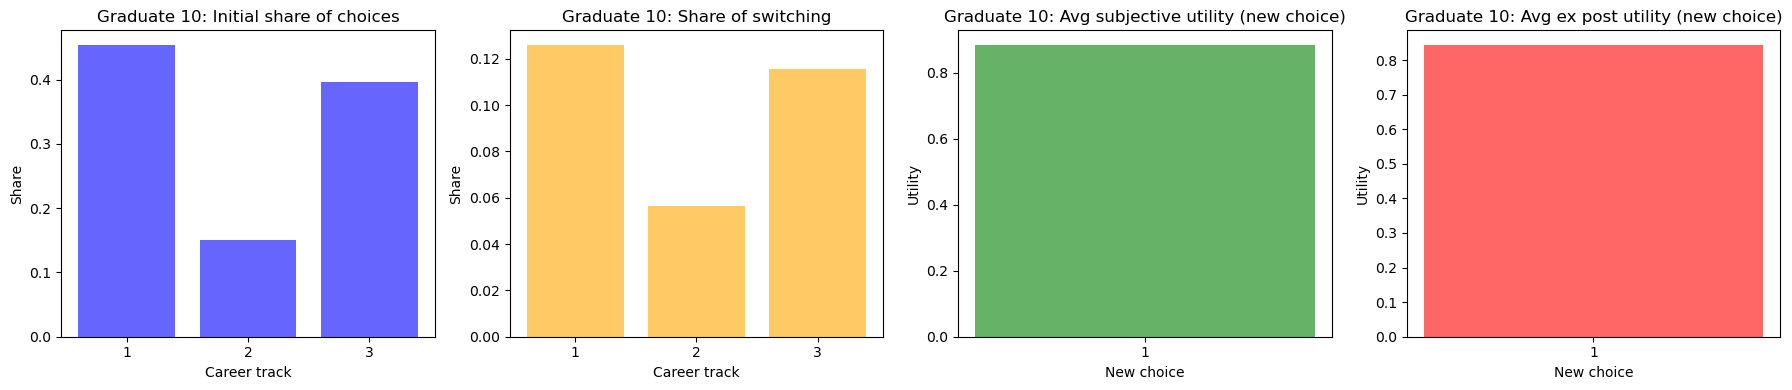

,Graduate Type,Initial Choice Share (Career 1),Initial Choice Share (Career 2),Initial Choice Share (Career 3),Switching Share (Initial Career 1),Switching Share (Initial Career 2),Switching Share (Initial Career 3),Avg Subjective Utility (New Choice),Avg Ex Post Utility (New Choice)
0,1,0.3739,0.2706,0.3555,0.1205,0.1044,0.1091,0.963334,0.669767
1,2,0.3870,0.2432,0.3698,0.1204,0.0962,0.1116,0.891762,0.745993
2,3,0.4028,0.2233,0.3739,0.1203,0.0878,0.1120,0.874025,0.802378
3,4,0.4032,0.2174,0.3794,0.1172,0.0833,0.1145,0.866047,0.785669
4,5,0.4176,0.1956,0.3868,0.1163,0.0709,0.1142,0.892071,0.846156
5,6,0.4307,0.1882,0.3811,0.1216,0.0697,0.1145,0.856344,0.807024
6,7,0.4326,0.1755,0.3919,0.1214,0.0676,0.1200,0.853585,0.815372
7,8,0.4389,0.1626,0.3985,0.1200,0.0612,0.1159,0.867738,0.837238
8,9,0.4364,0.1637,0.3999,0.1215,0.0619,0.1086,0.894352,0.854782
9,10,0.4541,0.1500,0.3959,0.1260,0.0564,0.1155,0.883702,0.843693


In [11]:
# write your answer here
# Arrays to store results
initial_choices = np.zeros((par.N, par.K), dtype=int)
new_choices = np.zeros((par.N, par.K), dtype=int)
initial_subjective_expected_utilities = np.zeros((par.N, par.K))
initial_ex_post_realised_utilities = np.zeros((par.N, par.K))
new_subjective_expected_utilities = np.zeros((par.N, par.K))
new_ex_post_realised_utilities = np.zeros((par.N, par.K))
switch_bool = np.zeros((par.N, par.K), dtype=bool)
vj = np.random.rand(par.J) # Randomly generate a value between 0 and 1 for the true utility for each career track

for i in range(1, par.N + 1):
    # Number of friends for each graduate i
    Fi = i 
    
    for k in range(par.K):
        # Draw friends' noise terms
        friends_noise_terms = np.random.normal(0, par.sigma, size = (Fi, par.J))

        # Calculate prior expected utility for each career track j
        prior_expected_utilities = vj + np.mean(friends_noise_terms, axis=0)

        # Determine initial career choice with maximum prior expected utility
        chosen_index = np.argmax(prior_expected_utilities)
        initial_choices[i - 1, k] = chosen_index

        # Store inital subjective expected utilities in array
        initial_subjective_expected_utilities[i - 1, k] = prior_expected_utilities[chosen_index]

        # Draw individual's noise term
        own_noise_term = np.random.normal(0, par.sigma, size = par.J)
        initial_ex_post_realised_utilities[i - 1, k] = vj[chosen_index] + own_noise_term[chosen_index]

        # Calculate new prior expected utility from new optimal career choice
        new_prior_expected_utilities = prior_expected_utilities.copy()
        new_prior_expected_utilities -= par.c
        new_prior_expected_utilities[chosen_index] = initial_ex_post_realised_utilities[i - 1, k]

        # Determine new optimal career choice with maximum new prior expected utility 
        new_chosen_index = np.argmax(new_prior_expected_utilities)
        new_choices[i - 1, k] = new_chosen_index

        # Store new subjective expected utilities in array
        new_subjective_expected_utilities[i - 1, k] = new_prior_expected_utilities[new_chosen_index]

        # Calculate new ex post realised utility of the new career
        if new_chosen_index == chosen_index:
            new_ex_post_realised_utilities[i - 1, k] = initial_ex_post_realised_utilities[i - 1, k]
        else:
            new_ex_post_realised_utilities[i - 1, k] = vj[new_chosen_index] + own_noise_term[new_chosen_index] - par.c
        
        # Record if the graduate switched careers
        switch_bool[i - 1, k] = (new_chosen_index != chosen_index)

# Calculate average subjective expected utilities, and ex post realised utilities of new optimal career choice
new_average_subjective_expected_utilities = np.mean(new_subjective_expected_utilities, axis=1)
new_average_ex_post_realised_utilities = np.mean(new_ex_post_realised_utilities, axis=1)

# Calculate share of graduates who choose to switch careers
switching_share = np.zeros((par.N, par.J))
for i in range(par.N):
    for j in range(par.J):
        switching_share[i, j] = np.mean((initial_choices[i, :] == j) & switch_bool[i, :])


# Visualise the results using bar charts
career_tracks = np.arange(1, par.J + 1)
for i in range(par.N):
    plt.figure(figsize=(18, 4))

    # Share of graduates choosing each career initially
    plt.subplot(1, 4, 1)
    plt.bar(career_tracks, [np.mean(initial_choices[i, :] == j) for j in range(par.J)], color='b', alpha=0.6)
    plt.title(f'Graduate {i + 1}: Initial share of choices')
    plt.xlabel('Career track')
    plt.ylabel('Share')
    plt.xticks(career_tracks)

    # Share of graduates choosing to switch from each initial career
    plt.subplot(1, 4, 2)
    plt.bar(career_tracks, switching_share[i, :], color='orange', alpha=0.6)
    plt.title(f'Graduate {i + 1}: Share of switching')
    plt.xlabel('Career track')
    plt.ylabel('Share')
    plt.xticks(career_tracks)

    # Average subjective expected utility of new choice
    plt.subplot(1, 4, 3)
    plt.bar([1], [new_average_subjective_expected_utilities[i]], color='g', alpha=0.6)
    plt.title(f'Graduate {i + 1}: Avg subjective utility (new choice)')
    plt.xlabel('New choice')
    plt.ylabel('Utility')
    plt.xticks([1])

    # Average ex post realized utility of new choice
    plt.subplot(1, 4, 4)
    plt.bar([1], [new_average_ex_post_realised_utilities[i]], color='r', alpha=0.6)
    plt.title(f'Graduate {i + 1}: Avg ex post utility (new choice)')
    plt.xlabel('New choice')
    plt.ylabel('Utility')
    plt.xticks([1])

    plt.tight_layout()
    plt.show()

# Display calculations in a pandas dataframe
data = []
for i in range(par.N):
    initial_career_distribution = [np.mean(initial_choices[i, :] == j) for j in range(par.J)]
    switching_shares_list = switching_share[i, :].tolist()
    data.append([i + 1] + initial_career_distribution + switching_shares_list +
                [new_average_subjective_expected_utilities[i], new_average_ex_post_realised_utilities[i]])

# Define column headers
columns = ["Graduate Type"] + \
          [f"Initial Choice Share (Career {j + 1})" for j in range(par.J)] + \
          [f"Switching Share (Initial Career {j + 1})" for j in range(par.J)] + \
          ["Avg Subjective Utility (New Choice)", "Avg Ex Post Utility (New Choice)"]

# Create DataFrame
df = pd.DataFrame(data, columns=columns)

df

## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [12]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))


**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

Point y: [0.20901926 0.37774759]
Point A: [0.26071605 0.43635845]
Point B: [0.21315735 0.274245  ]
Point C: [0.10056103 0.27951775]
Point D: [0.20634391 0.44272557]


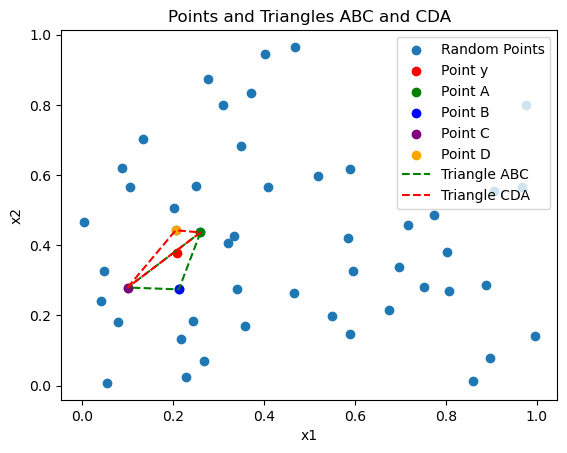

In [13]:
# write your answer here
from matplotlib import pyplot as plt


def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)


# Find points A, B, C, D based on the criteria provided
A_candidates = [p for p in X if p[0] > y[0] and p[1] > y[1]]
B_candidates = [p for p in X if p[0] > y[0] and p[1] < y[1]]
C_candidates = [p for p in X if p[0] < y[0] and p[1] < y[1]]
D_candidates = [p for p in X if p[0] < y[0] and p[1] > y[1]]

A = min(A_candidates, key=lambda p: euclidean_distance(p, y))
B = min(B_candidates, key=lambda p: euclidean_distance(p, y))
C = min(C_candidates, key=lambda p: euclidean_distance(p, y))
D = min(D_candidates, key=lambda p: euclidean_distance(p, y))

# Print the points
print(f"Point y: {y}")
print(f"Point A: {A}")
print(f"Point B: {B}")
print(f"Point C: {C}")
print(f"Point D: {D}")

# Plot points and triangles
plt.scatter(X[:, 0], X[:, 1], label='Random Points')
plt.scatter(*y, color='red', label='Point y')
plt.scatter(*A, color='green', label='Point A')
plt.scatter(*B, color='blue', label='Point B')
plt.scatter(*C, color='purple', label='Point C')
plt.scatter(*D, color='orange', label='Point D')

# Plot triangles ABC and CDA
triangle_ABC = np.array([A, B, C, A])
triangle_CDA = np.array([C, D, A, C])

plt.plot(triangle_ABC[:, 0], triangle_ABC[:, 1], 'g--', label='Triangle ABC')
plt.plot(triangle_CDA[:, 0], triangle_CDA[:, 1], 'r--', label='Triangle CDA')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Points and Triangles ABC and CDA')
plt.show()

**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

In [14]:
# write your answer here

# Function to compute barycentric coordinates
def barycentric_coordinates(A, B, C, P):
    denom = (B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1])
    r1 = ((B[1] - C[1]) * (P[0] - C[0]) + (C[0] - B[0]) * (P[1] - C[1])) / denom
    r2 = ((C[1] - A[1]) * (P[0] - C[0]) + (A[0] - C[0]) * (P[1] - C[1])) / denom
    r3 = 1 - r1 - r2
    return r1, r2, r3

# Function to check if point is inside the triangle
def is_inside_triangle(r1, r2, r3):
    return 0 <= r1 <= 1 and 0 <= r2 <= 1 and 0 <= r3 <= 1

# Compute barycentric coordinates for triangle ABC
r1_ABC, r2_ABC, r3_ABC = barycentric_coordinates(A, B, C, y)
inside_ABC = is_inside_triangle(r1_ABC, r2_ABC, r3_ABC)

# Compute barycentric coordinates for triangle CDA
r1_CDA, r2_CDA, r3_CDA = barycentric_coordinates(C, D, A, y)
inside_CDA = is_inside_triangle(r1_CDA, r2_CDA, r3_CDA)

# Print the results
print(f"Point y: {y}")
print(f"Point A: {A}")
print(f"Point B: {B}")
print(f"Point C: {C}")
print(f"Point D: {D}")

print(f"\nBarycentric coordinates with respect to ABC: r1 = {r1_ABC}, r2 = {r2_ABC}, r3 = {r3_ABC}")
print(f"Is y inside ABC? {inside_ABC}")

print(f"\nBarycentric coordinates with respect to CDA: r1 = {r1_CDA}, r2 = {r2_CDA}, r3 = {r3_CDA}")
print(f"Is y inside CDA? {inside_CDA}")

# Determine which triangle y is inside
if inside_ABC:
    print("Point y is inside triangle ABC.")
elif inside_CDA:
    print("Point y is inside triangle CDA.")
else:
    print("Point y is not inside any triangle.")


Point y: [0.20901926 0.37774759]
Point A: [0.26071605 0.43635845]
Point B: [0.21315735 0.274245  ]
Point C: [0.10056103 0.27951775]
Point D: [0.20634391 0.44272557]

Barycentric coordinates with respect to ABC: r1 = 0.6286263152916166, r2 = 0.06910145494351515, r3 = 0.3022722297648682
Is y inside ABC? True

Barycentric coordinates with respect to CDA: r1 = 0.3682598757102867, r2 = -0.13392661883334067, r3 = 0.765666743123054
Is y inside CDA? False
Point y is inside triangle ABC.


Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [15]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

In [16]:
# write your answer here

# Compute barycentric coordinates for triangle ABC
r1_ABC, r2_ABC, r3_ABC = barycentric_coordinates(A, B, C, y)
inside_ABC = is_inside_triangle(r1_ABC, r2_ABC, r3_ABC)

# Compute barycentric coordinates for triangle CDA
r1_CDA, r2_CDA, r3_CDA = barycentric_coordinates(C, D, A, y)
inside_CDA = is_inside_triangle(r1_CDA, r2_CDA, r3_CDA)

# Compute the interpolated value
if inside_ABC:
    f_y = r1_ABC * f(A) + r2_ABC * f(B) + r3_ABC * f(C)
    triangle = "ABC"
elif inside_CDA:
    f_y = r1_CDA * f(C) + r2_CDA * f(D) + r3_CDA * f(A)
    triangle = "CDA"
else:
    f_y = np.nan
    triangle = "None"

# Compute the true value
true_value = f(y)

# Print the results
print(f"\nTriangle containing y: {triangle}")
print(f"Interpolated value at y: {f_y}")
print(f"True value at y: {true_value}")
print(f"Difference between true value and interpolated value: {abs(true_value - f_y)}")



Triangle containing y: ABC
Interpolated value at y: 0.08405201731052576
True value at y: 0.0789565216259594
Difference between true value and interpolated value: 0.005095495684566367


**Question 4:** Repeat question 3 for all points in the set $Y$.

Assuming one if the point in (0.8,0.2) is meant to be (0.2,0.8)

In [17]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.2,0.8),(0.5,0.5)]

Point y: [0.2 0.2]
Triangle containing y: None
Interpolated value at y: nan
True value at y: 0.04000000000000001
Difference between true value and interpolated value: nan

Point y: [0.8 0.2]
Triangle containing y: None
Interpolated value at y: nan
True value at y: 0.16000000000000003
Difference between true value and interpolated value: nan

Point y: [0.8 0.8]
Triangle containing y: None
Interpolated value at y: nan
True value at y: 0.6400000000000001
Difference between true value and interpolated value: nan

Point y: [0.2 0.8]
Triangle containing y: None
Interpolated value at y: nan
True value at y: 0.16000000000000003
Difference between true value and interpolated value: nan

Point y: [0.5 0.5]
Triangle containing y: None
Interpolated value at y: nan
True value at y: 0.25
Difference between true value and interpolated value: nan



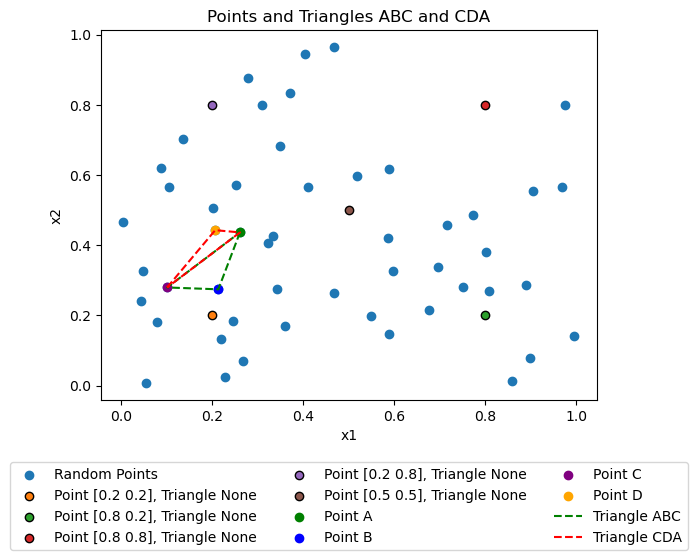

In [18]:
# write your answer here

# Function to process each point in Y
from matplotlib import pyplot as plt


def process_point(y):
    y = np.array(y)
    # Compute barycentric coordinates for triangle ABC
    r1_ABC, r2_ABC, r3_ABC = barycentric_coordinates(A, B, C, y)
    inside_ABC = is_inside_triangle(r1_ABC, r2_ABC, r3_ABC)

    # Compute barycentric coordinates for triangle CDA
    r1_CDA, r2_CDA, r3_CDA = barycentric_coordinates(C, D, A, y)
    inside_CDA = is_inside_triangle(r1_CDA, r2_CDA, r3_CDA)

    # Compute the interpolated value
    if inside_ABC:
        f_y = r1_ABC * f(A) + r2_ABC * f(B) + r3_ABC * f(C)
        triangle = "ABC"
    elif inside_CDA:
        f_y = r1_CDA * f(C) + r2_CDA * f(D) + r3_CDA * f(A)
        triangle = "CDA"
    else:
        f_y = np.nan
        triangle = "None"

    # Compute the true value
    true_value = f(y)

    # Print the results
    print(f"Point y: {y}")
    print(f"Triangle containing y: {triangle}")
    print(f"Interpolated value at y: {f_y}")
    print(f"True value at y: {true_value}")
    print(f"Difference between true value and interpolated value: {abs(true_value - f_y)}\n")

    return y, f_y, true_value, triangle

# Process all points in Y
results = [process_point(y) for y in Y]

# Plot points and triangles
plt.scatter(X[:, 0], X[:, 1], label='Random Points')
for result in results:
    y, f_y, true_value, triangle = result
    plt.scatter(*y, label=f'Point {y}, Triangle {triangle}', edgecolor='black')

plt.scatter(*A, color='green', label='Point A')
plt.scatter(*B, color='blue', label='Point B')
plt.scatter(*C, color='purple', label='Point C')
plt.scatter(*D, color='orange', label='Point D')

# Plot triangles ABC and CDA
triangle_ABC = np.array([A, B, C, A])
triangle_CDA = np.array([C, D, A, C])

plt.plot(triangle_ABC[:, 0], triangle_ABC[:, 1], 'g--', label='Triangle ABC')
plt.plot(triangle_CDA[:, 0], triangle_CDA[:, 1], 'r--', label='Triangle CDA')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.title('Points and Triangles ABC and CDA')
plt.show()


The missing interpolated values at y indicates that none of the point in set the set Y are either any of the two triangles